# Regression example using TF-MELT
This is a basic regression example using the models in TF-MELT.

Requires the following additional packages:
* ipykernel
* scikit-learn
* matplotlib

In [1]:
import sklearn.datasets as sdt
import matplotlib.pyplot as plt

# Create surogate data
n_samples = 1000
n_features = 10
n_info = 5
n_targets = 3
noise = 10

x, y = sdt.make_regression(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=n_info, 
    n_targets=n_targets, 
    noise=noise, 
    random_state=42,
)
print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Shape of x: (1000, 10), Shape of y: (1000, 3)


In [2]:
from tfmelt.utils.preprocessing import get_normalizers
from sklearn.model_selection import train_test_split

# Get the normalizers using the tfmelt library
x_normalizer, y_normalizer = get_normalizers(norm_type="standard", n_normalizers=2)

# Fit the normalizers
x_normalizer.fit(x)
y_normalizer.fit(y)

# Normalize the data
x_norm = x_normalizer.transform(x)
y_norm = y_normalizer.transform(y)

# Create the train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)

# Hyperparameters
Set consistent hyperparameters for all models for comparisons sake.

In [3]:
# General hyperparameters
n_epochs = 300
batch_size = 32
loss = "mse"
learn_rate = 1e-3
l1_reg = 0
l2_reg = 0
act_fun = "relu"
dropout = 0.1
input_dropout = 0.1
batch_norm = False
output_activation = "linear"

width = 8
depth = 2

# ResNet specific hyperparameters
layers_per_block = 4

## Artificial Neural Network (ANN)
Create and train an ANN using TF-MELT.

In [4]:
from tfmelt.models import ArtificialNeuralNetwork
from tensorflow.keras.optimizers import Adam

# Create the model
ann_model = ArtificialNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    output_activation=output_activation,
)

# Compile the model
ann_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
ann_model.build(input_shape=(None, n_features))
ann_model.summary()


Model: "artificial_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_dropout (Dropout)     multiple                  0         
                                                                 
 output (DefaultOutput)      multiple                  27        
                                                                 
 dense_block (DenseBlock)    multiple                  160       
                                                                 
Total params: 187 (748.00 Byte)
Trainable params: 187 (748.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output (Dense)              multiple                  27        
                                                     

In [5]:
# Train the model
history = ann_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 0s 3ms/step - loss: 1.2997 - val_loss: 1.5674
Epoch 2/300
25/25 [==============================] - 0s 953us/step - loss: 1.0812 - val_loss: 1.3508
Epoch 3/300
25/25 [==============================] - 0s 921us/step - loss: 0.9563 - val_loss: 1.1908
Epoch 4/300
25/25 [==============================] - 0s 858us/step - loss: 0.8557 - val_loss: 1.0671
Epoch 5/300
25/25 [==============================] - 0s 713us/step - loss: 0.7564 - val_loss: 0.9531
Epoch 6/300
25/25 [==============================] - 0s 695us/step - loss: 0.7019 - val_loss: 0.8501
Epoch 7/300
25/25 [==============================] - 0s 690us/step - loss: 0.6337 - val_loss: 0.7461
Epoch 8/300
25/25 [==============================] - 0s 700us/step - loss: 0.5682 - val_loss: 0.6492
Epoch 9/300
25/25 [==============================] - 0s 702us/step - loss: 0.5498 - val_loss: 0.5701
Epoch 10/300
25/25 [==============================] - 0s 694us/step - loss: 0.4679 - val_loss

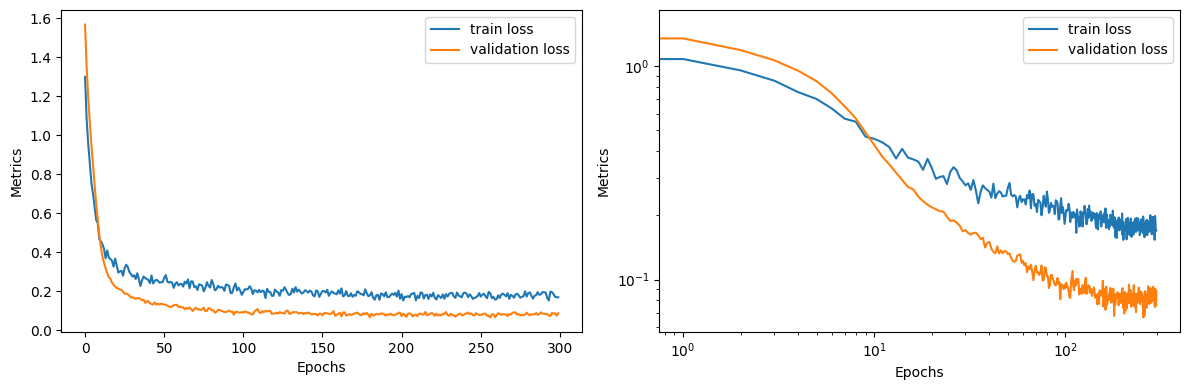

In [6]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=True)

In [7]:
from tfmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train = make_predictions(ann_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val = make_predictions(ann_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test = make_predictions(ann_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

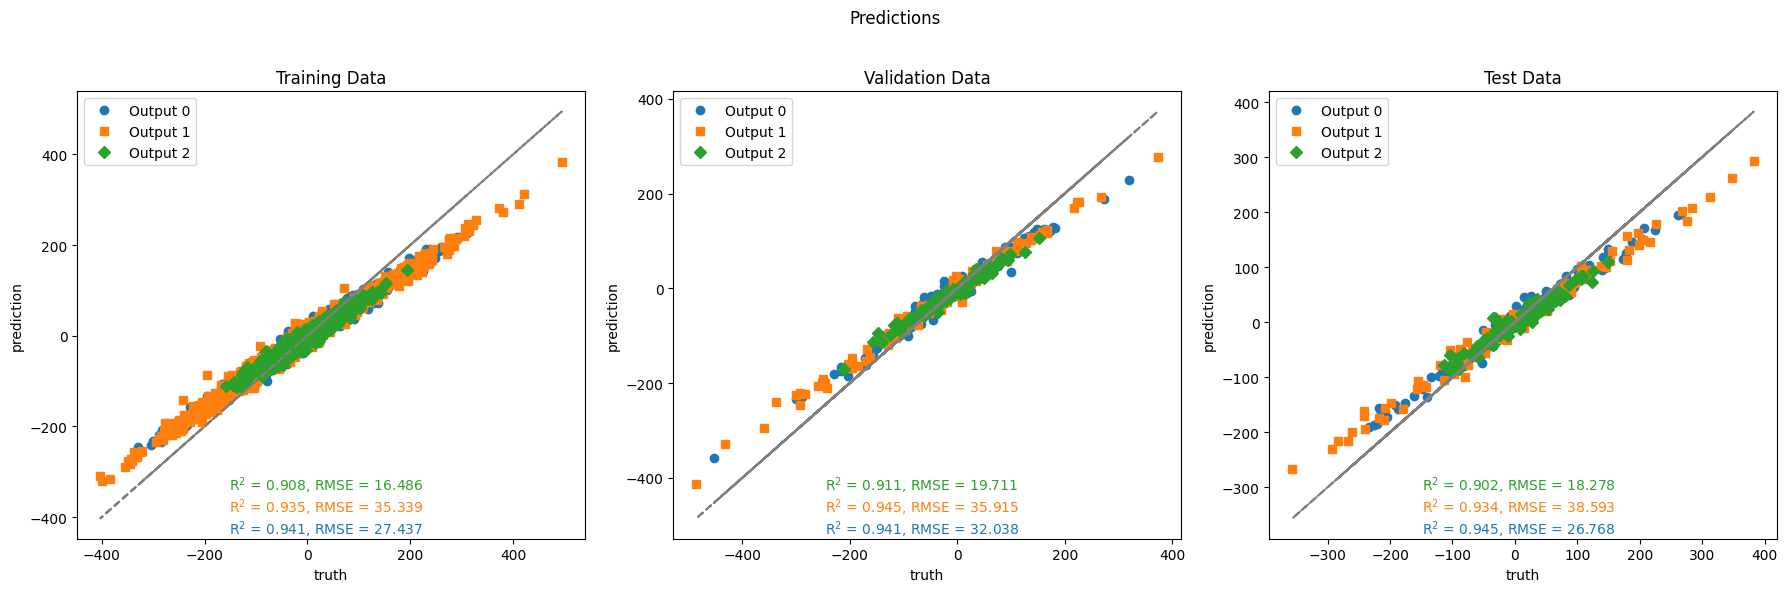

In [8]:
from tfmelt.utils.visualization import plot_predictions

# Plot the predictions
plot_predictions(pred_train, y_train_real, pred_val, y_val_real, pred_test, y_test_real)

Let's do a quick test to see if we can compute the gradients of the model...

Shape of tfmelt jacobian: (1, 3, 1, 10)


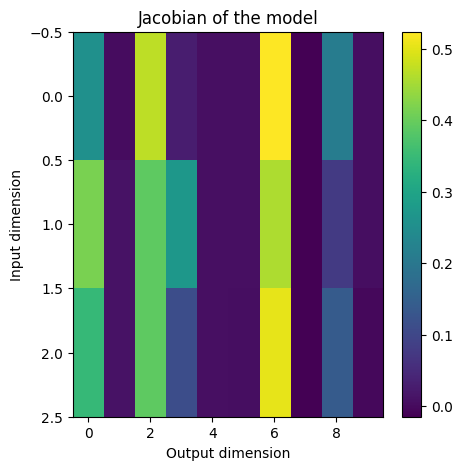

In [9]:
# Compute the tensorflow Jacobian
x_sample = x_train[0:1, :]
tfmelt_jacobian = ann_model.compute_jacobian(x_sample)

print(f"Shape of tfmelt jacobian: {tfmelt_jacobian.shape}")

# Plot the Jacobian
plt.figure(figsize=(5, 5))
cb = plt.imshow(tfmelt_jacobian[0, :, 0, :], cmap="viridis", aspect="auto")
plt.colorbar(cb)
plt.title("Jacobian of the model")
plt.xlabel("Output dimension")
plt.ylabel("Input dimension")
plt.show()


In [10]:
from tfmelt.utils.evaluation import ensemble_predictions

# Make ensemble predictions using MC Dropout
n_iter = 100
pred_train_mean, pred_train_std = ensemble_predictions(ann_model, x_train, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_val_mean, pred_val_std = ensemble_predictions(ann_model, x_val, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_test_mean, pred_test_std = ensemble_predictions(ann_model, x_test, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)


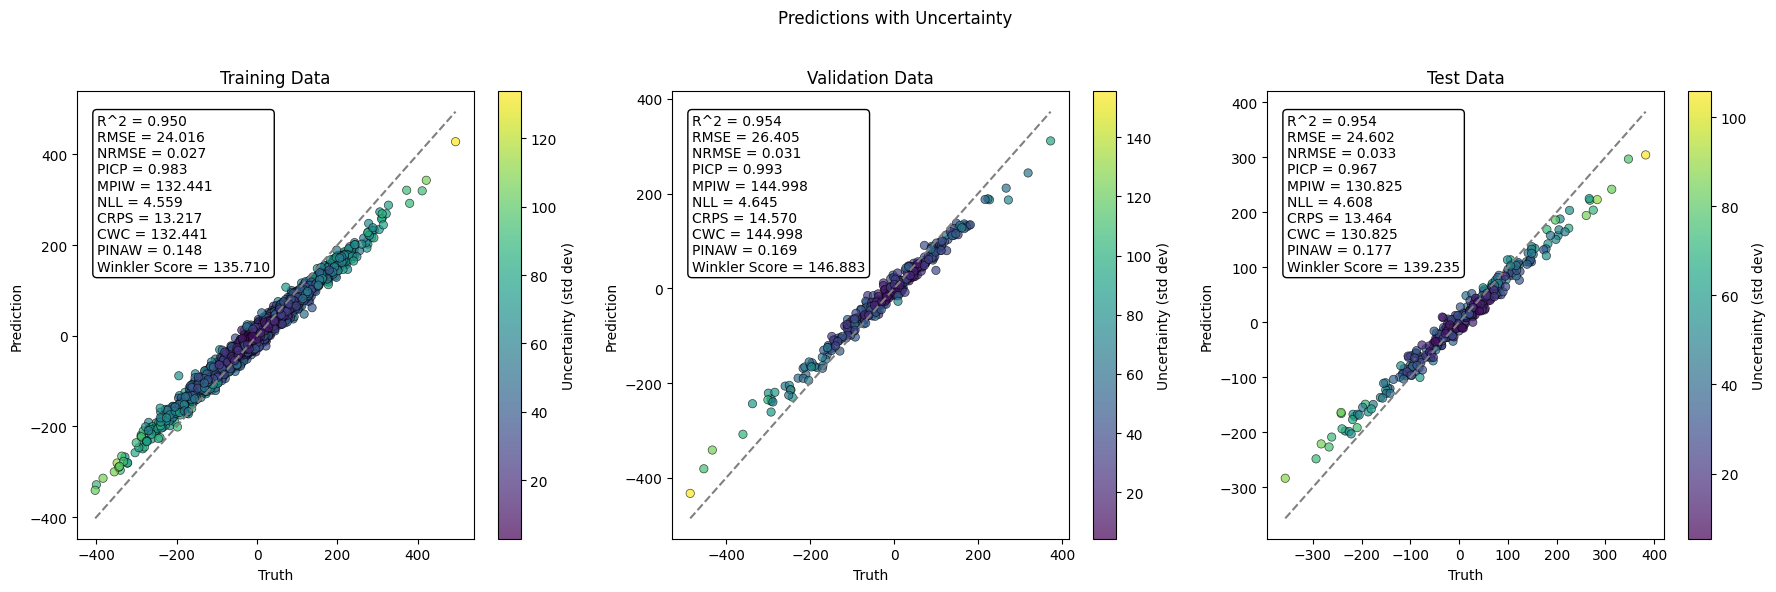

In [11]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot MC Dropout predictions
plot_predictions_with_uncertainty(
    pred_train_mean, pred_train_std, y_train_real,
    pred_val_mean, pred_val_std, y_val_real,
    pred_test_mean, pred_test_std, y_test_real,
    # metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"],
    metrics_to_display=None, # Display all metrics
)

## Residual Neural Network (ResNet)
Create and train a ResNet using TF-MELT.

In [12]:
from tfmelt.models import ResidualNeuralNetwork
from tensorflow.keras.optimizers import Adam

# Create the model
resnet_model = ResidualNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    layers_per_block=layers_per_block,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    pre_activation=True,
    post_add_activation=False,
    output_activation=output_activation,
)

# Compile the model
resnet_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
resnet_model.build(input_shape=(None, n_features))
resnet_model.summary()


Model: "residual_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_dropout (Dropout)     multiple                  0         
                                                                 
 output (DefaultOutput)      multiple                  27        
                                                                 
 residual_block (ResidualBl  multiple                  160       
 ock)                                                            
                                                                 
Total params: 187 (748.00 Byte)
Trainable params: 187 (748.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output (Dense)              multiple                  

/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tfmelt/models.py:320: UserWarning: Warning: Number of layers (2) is not divisible by layers_per_block (4), so the last block will have 2 layers.
  warnings.warn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tfmelt/blocks.py:210: UserWarning: Warning: Number of layers (2) is not divisible by layers_per_block (4), so the last block will have 2 layers.
  warnings.warn(


In [13]:
# Train the model
history = resnet_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 0s 2ms/step - loss: 3.7627 - val_loss: 3.3887
Epoch 2/300
25/25 [==============================] - 0s 956us/step - loss: 2.5801 - val_loss: 2.6224
Epoch 3/300
25/25 [==============================] - 0s 906us/step - loss: 1.9732 - val_loss: 2.1632
Epoch 4/300
25/25 [==============================] - 0s 855us/step - loss: 1.5946 - val_loss: 1.8493
Epoch 5/300
25/25 [==============================] - 0s 687us/step - loss: 1.4052 - val_loss: 1.6327
Epoch 6/300
25/25 [==============================] - 0s 697us/step - loss: 1.2311 - val_loss: 1.4485
Epoch 7/300
25/25 [==============================] - 0s 688us/step - loss: 1.0529 - val_loss: 1.3046
Epoch 8/300
25/25 [==============================] - 0s 671us/step - loss: 0.9765 - val_loss: 1.1745
Epoch 9/300
25/25 [==============================] - 0s 706us/step - loss: 0.9091 - val_loss: 1.0567
Epoch 10/300
25/25 [==============================] - 0s 692us/step - loss: 0.7988 - val_loss

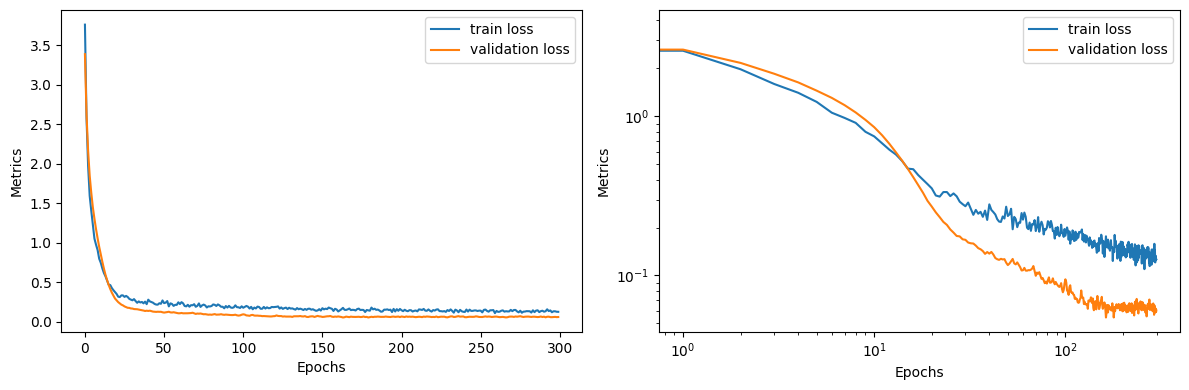

In [14]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=True)

In [15]:
from tfmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train = make_predictions(resnet_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val = make_predictions(resnet_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test = make_predictions(resnet_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

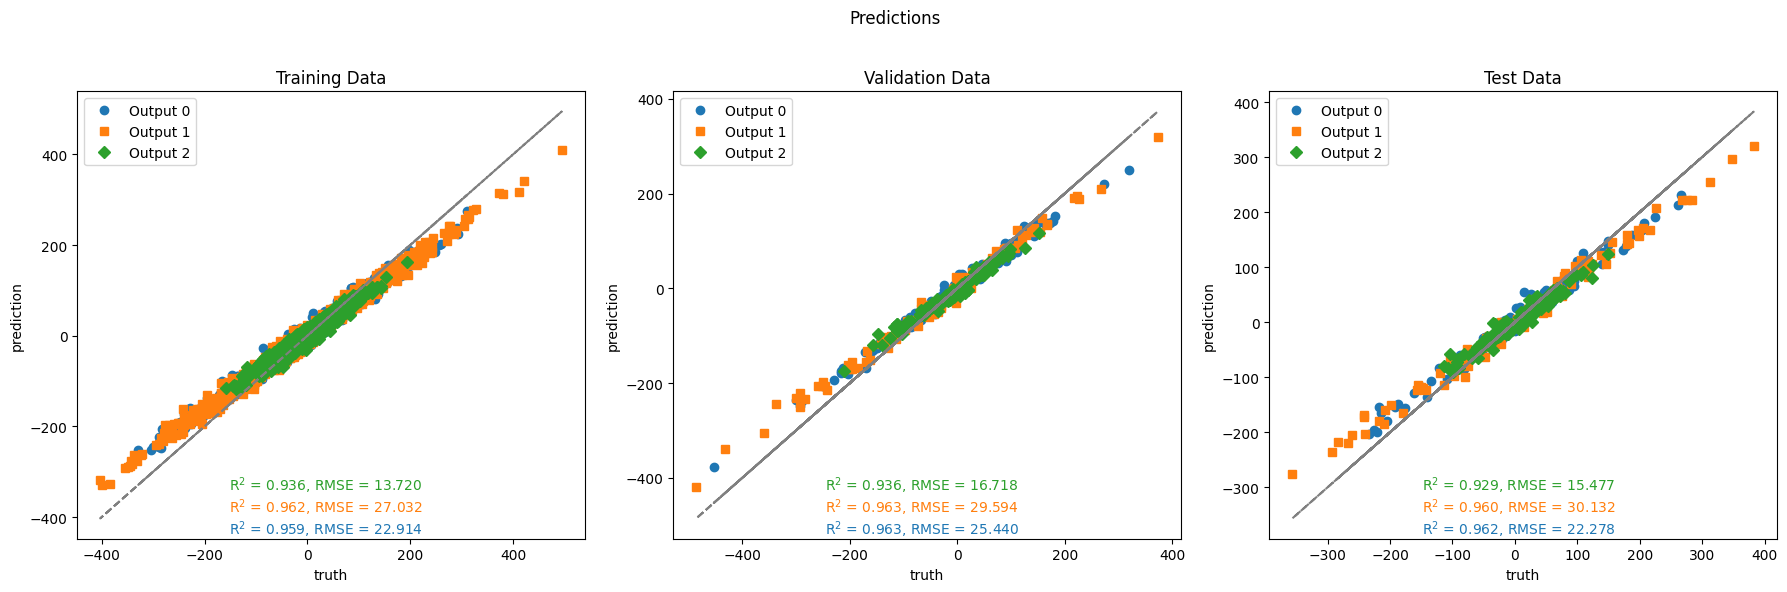

In [16]:
from tfmelt.utils.visualization import plot_predictions

# Plot the predictions
plot_predictions(pred_train, y_train_real, pred_val, y_val_real, pred_test, y_test_real)

In [17]:
from tfmelt.utils.evaluation import ensemble_predictions

# Make ensemble predictions using MC Dropout
n_iter = 100
pred_train_mean, pred_train_std = ensemble_predictions(resnet_model, x_train, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_val_mean, pred_val_std = ensemble_predictions(resnet_model, x_val, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_test_mean, pred_test_std = ensemble_predictions(resnet_model, x_test, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)

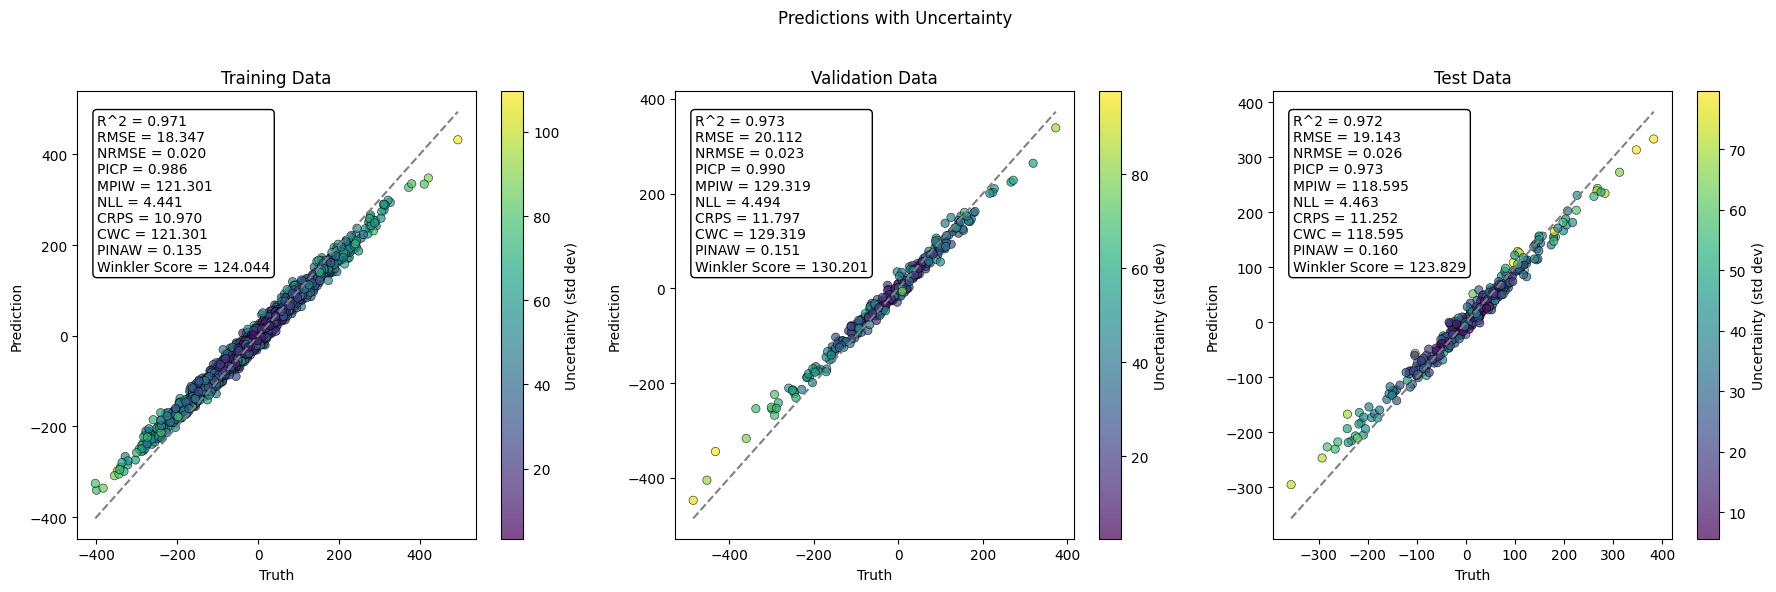

In [18]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot MC Dropout predictions
plot_predictions_with_uncertainty(
    pred_train_mean, pred_train_std, y_train_real,
    pred_val_mean, pred_val_std, y_val_real,
    pred_test_mean, pred_test_std, y_test_real,
    # metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"]
    metrics_to_display=None, # Display all metrics
)

# Heteroscedastic ANN

Now enable the direct uncertainty prediction using a modified output layer through num_mixtures parameter

In [19]:
from tfmelt.models import ArtificialNeuralNetwork
from tensorflow.keras.optimizers import Adam

# Create the model
hnn_model = ArtificialNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=0.0, # Remove input dropout
    dropout=0.0, # Remove dropout
    batch_norm=batch_norm,
    output_activation=output_activation,
    num_mixtures=1, # Single Gaussian mixture
)

# Compile the model
hnn_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
hnn_model.build(input_shape=(None, n_features))
hnn_model.summary()

Model: "artificial_neural_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 single_mixture_output (Sin  multiple                  54        
 gleMixtureOutput)                                               
                                                                 
 dense_block (DenseBlock)    multiple                  160       
                                                                 
Total params: 214 (856.00 Byte)
Trainable params: 214 (856.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "single_mixture_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mean_output (Dense)         multiple                  27        
                                                                 
 log_var_output (Dense)      multipl

/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tfmelt/models.py:193: UserWarning: Loss function is overridden when using aleatoric uncertainty. Using the aleatoric loss function.
  warnings.warn(


In [20]:
# Train the model
history = hnn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 0s 3ms/step - loss: 2.0236 - val_loss: 2.0569
Epoch 2/300
25/25 [==============================] - 0s 927us/step - loss: 1.4427 - val_loss: 1.7432
Epoch 3/300
25/25 [==============================] - 0s 983us/step - loss: 1.2126 - val_loss: 1.5816
Epoch 4/300
25/25 [==============================] - 0s 800us/step - loss: 1.0972 - val_loss: 1.4739
Epoch 5/300
25/25 [==============================] - 0s 709us/step - loss: 1.0189 - val_loss: 1.3896
Epoch 6/300
25/25 [==============================] - 0s 706us/step - loss: 0.9605 - val_loss: 1.3231
Epoch 7/300
25/25 [==============================] - 0s 686us/step - loss: 0.9105 - val_loss: 1.2594
Epoch 8/300
25/25 [==============================] - 0s 692us/step - loss: 0.8631 - val_loss: 1.2039
Epoch 9/300
25/25 [==============================] - 0s 700us/step - loss: 0.8140 - val_loss: 1.1422
Epoch 10/300
25/25 [==============================] - 0s 692us/step - loss: 0.7612 - val_loss

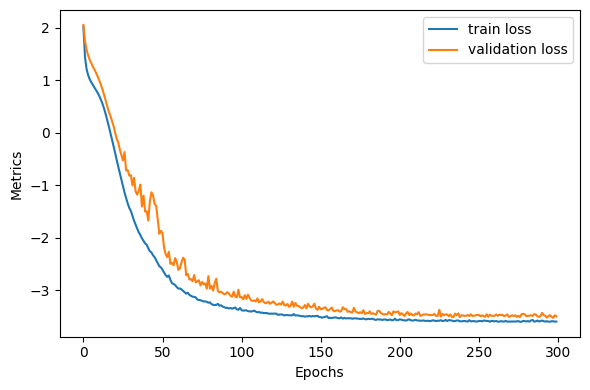

In [21]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=False)

In [22]:
from tfmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train, pred_train_std = make_predictions(hnn_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val, pred_val_std = make_predictions(hnn_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test, pred_test_std = make_predictions(hnn_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

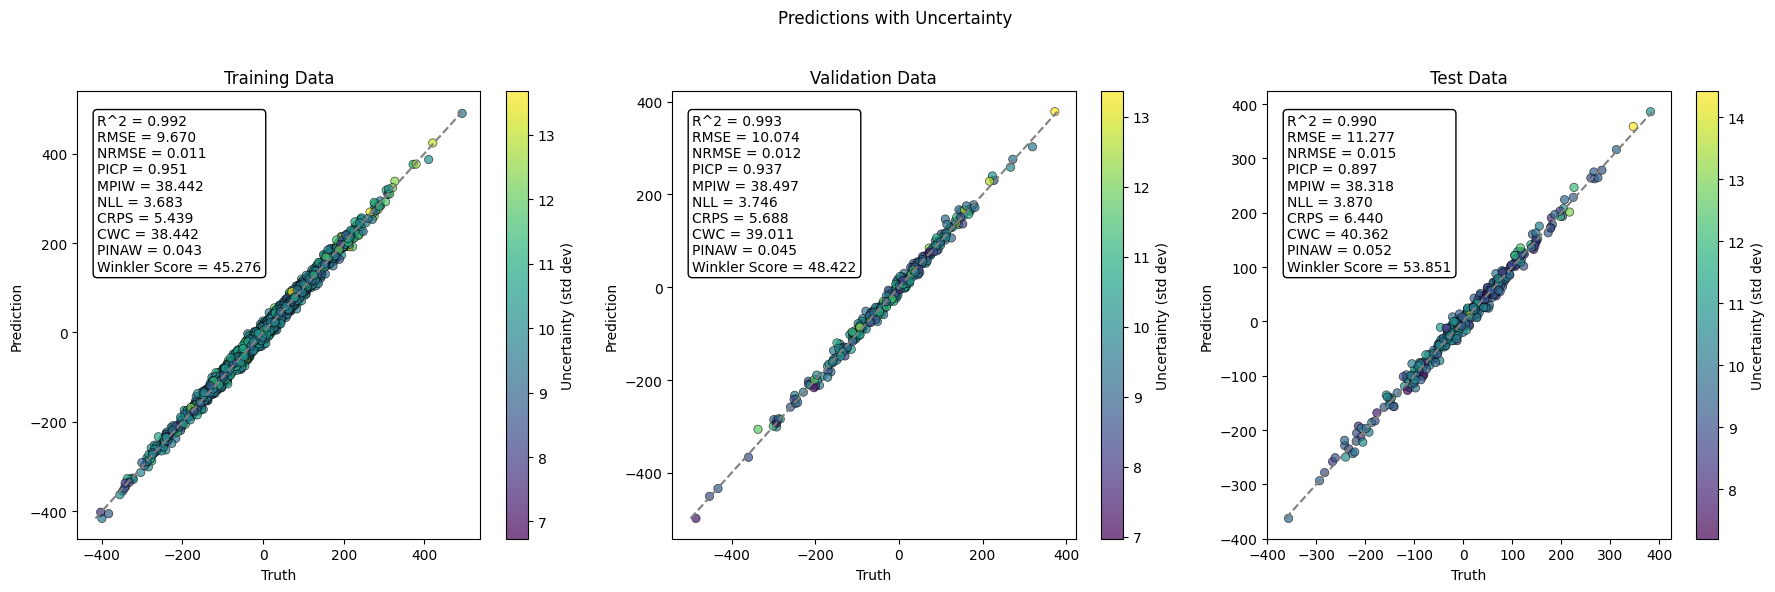

In [23]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot the predictions
plot_predictions_with_uncertainty(
    pred_train, pred_train_std, y_train_real,
    pred_val, pred_val_std, y_val_real,
    pred_test, pred_test_std, y_test_real,
    # metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"]
    metrics_to_display=None, # Display all metrics
)


# Mixture Density Network
Now increase the number of mixture models for a true MDN

In [24]:
from tfmelt.models import ArtificialNeuralNetwork
from tensorflow.keras.optimizers import Adam

# Create the model
mdn_model = ArtificialNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=0.0, # Remove input dropout
    dropout=0.0, # Remove dropout
    batch_norm=batch_norm,
    output_activation=output_activation,
    num_mixtures=5, # 5 Gaussian mixtures
)

# Compile the model
mdn_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
mdn_model.build(input_shape=(None, n_features))
mdn_model.summary()

Model: "artificial_neural_network_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 multiple_mixture_output (M  multiple                  315       
 ultipleMixturesOutput)                                          
                                                                 
 dense_block (DenseBlock)    multiple                  160       
                                                                 
Total params: 475 (1.86 KB)
Trainable params: 475 (1.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "multiple_mixture_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mix_coeffs (Dense)          multiple                  45        
                                                                 
 mean_output (Dense)         multiple     

/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tfmelt/models.py:199: UserWarning: Loss function is overridden when using mixture density networks. Using the mixture density loss function.
  warnings.warn(


In [25]:
# Train the model
history = mdn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 0s 3ms/step - loss: 3.3001 - val_loss: 3.4455
Epoch 2/300
25/25 [==============================] - 0s 1ms/step - loss: 3.2644 - val_loss: 3.4320
Epoch 3/300
25/25 [==============================] - 0s 1ms/step - loss: 3.2459 - val_loss: 3.4256
Epoch 4/300
25/25 [==============================] - 0s 964us/step - loss: 3.2346 - val_loss: 3.4199
Epoch 5/300
25/25 [==============================] - 0s 761us/step - loss: 3.2262 - val_loss: 3.4126
Epoch 6/300
25/25 [==============================] - 0s 767us/step - loss: 3.2177 - val_loss: 3.4038
Epoch 7/300
25/25 [==============================] - 0s 741us/step - loss: 3.2062 - val_loss: 3.3861
Epoch 8/300
25/25 [==============================] - 0s 754us/step - loss: 3.1902 - val_loss: 3.3543
Epoch 9/300
25/25 [==============================] - 0s 753us/step - loss: 3.1653 - val_loss: 3.3113
Epoch 10/300
25/25 [==============================] - 0s 760us/step - loss: 3.1267 - val_loss: 3.

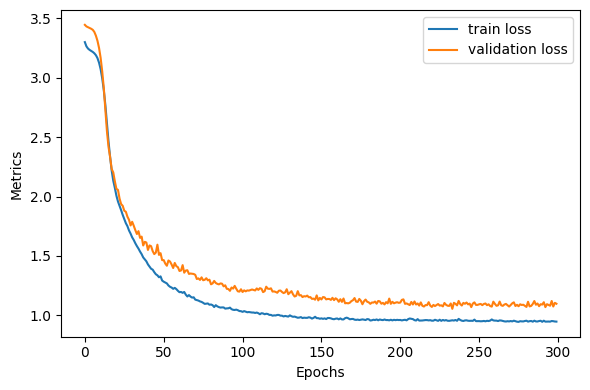

In [26]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=False)

In [27]:
from tfmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train, pred_train_std = make_predictions(mdn_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val, pred_val_std = make_predictions(mdn_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test, pred_test_std = make_predictions(mdn_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

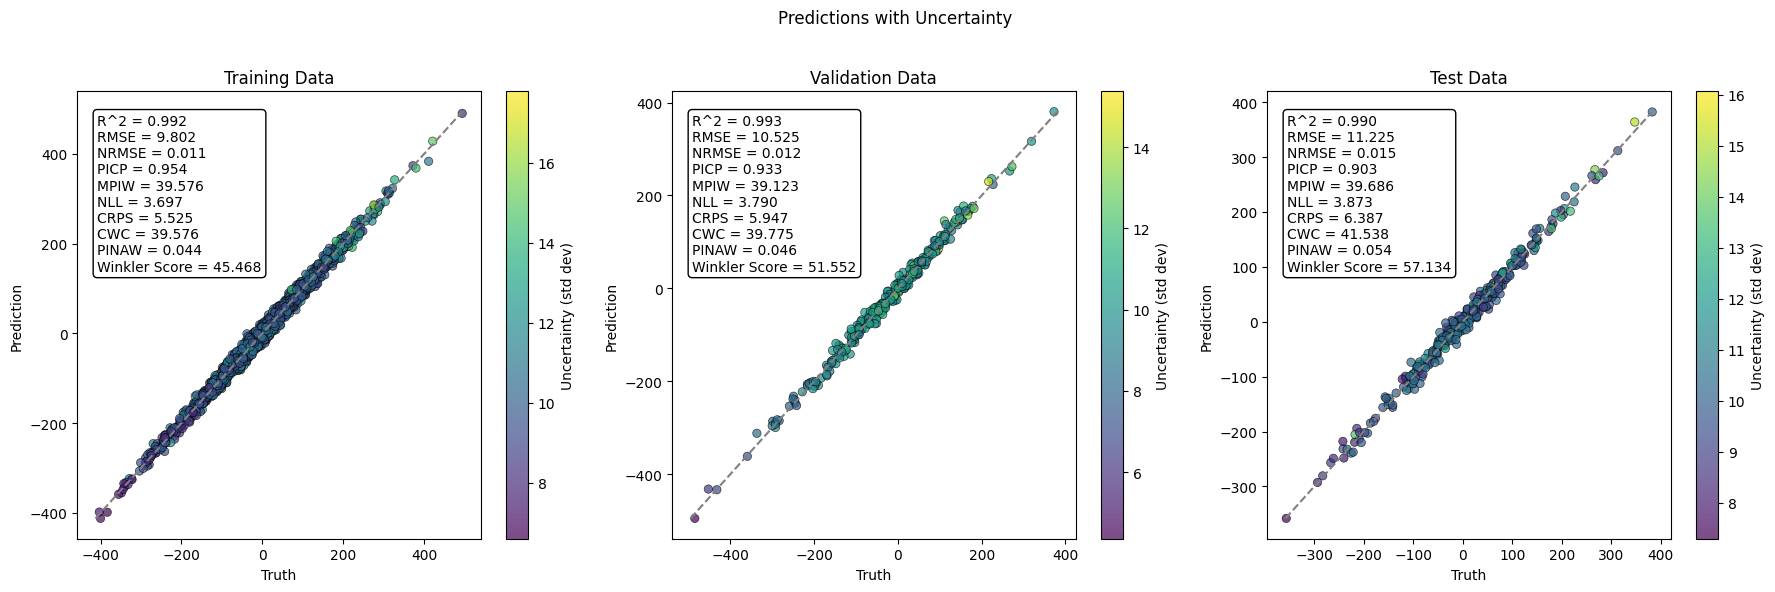

In [28]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot the predictions
plot_predictions_with_uncertainty(
    pred_train, pred_train_std, y_train_real,
    pred_val, pred_val_std, y_val_real,
    pred_test, pred_test_std, y_test_real,
    # metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"]
    metrics_to_display=None, # Display all metrics
)

## Bayesian Neural Network (BNN)
Create and train a BNN using TF-MELT. We can specify the number of bayesian layers desired to increase complexity.

#### Epistemic Uncertainty Predictions
We will turn off the aleatoric output layer and instead train an epistemic BNN model (of varying number of layers). Predictions will be made using Monte Carlo methods.

In [29]:
from tfmelt.models import BayesianNeuralNetwork
from tensorflow.keras.optimizers import Adam

# BNN specific hyperparameters
dropout = 0.0
input_dropout = 0.0
do_aleatoric = False

# We can create a BNN with arbitrary Bayesian layers
node_list = [8, 8, 8]
bayesian_mask = [True, False, True]

# Create the model
bnn_model = BayesianNeuralNetwork(
    num_outputs=n_targets,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    output_activation=output_activation,
    num_points=x_train.shape[0],
    do_aleatoric=do_aleatoric,
    node_list=node_list,
    bayesian_mask=bayesian_mask,
)

# Compile the model
bnn_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
bnn_model.build(input_shape=(None, n_features))
bnn_model.summary()


Model: "bayesian_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output (DefaultOutput)      multiple                  51        
                                                                 
 dense_block_0 (DenseBlock)  multiple                  72        
                                                                 
 bayesian_block_0 (Bayesian  multiple                  168       
 Block)                                                          
                                                                 
 bayesian_block_1 (Bayesian  multiple                  136       
 Block)                                                          
                                                                 
Total params: 427 (1.67 KB)
Trainable params: 427 (1.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "outpu

/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [30]:
# Train the model
history = bnn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 1s 7ms/step - loss: 1.4931 - val_loss: 1.9013
Epoch 2/300
25/25 [==============================] - 0s 1ms/step - loss: 1.4787 - val_loss: 1.8881
Epoch 3/300
25/25 [==============================] - 0s 1ms/step - loss: 1.4602 - val_loss: 1.8612
Epoch 4/300
25/25 [==============================] - 0s 1ms/step - loss: 1.4184 - val_loss: 1.8030
Epoch 5/300
25/25 [==============================] - 0s 836us/step - loss: 1.3310 - val_loss: 1.7019
Epoch 6/300
25/25 [==============================] - 0s 848us/step - loss: 1.1697 - val_loss: 1.5129
Epoch 7/300
25/25 [==============================] - 0s 847us/step - loss: 1.0432 - val_loss: 1.3990
Epoch 8/300
25/25 [==============================] - 0s 842us/step - loss: 0.9621 - val_loss: 1.3345
Epoch 9/300
25/25 [==============================] - 0s 851us/step - loss: 0.9139 - val_loss: 1.2570
Epoch 10/300
25/25 [==============================] - 0s 844us/step - loss: 0.8682 - val_loss: 1.19

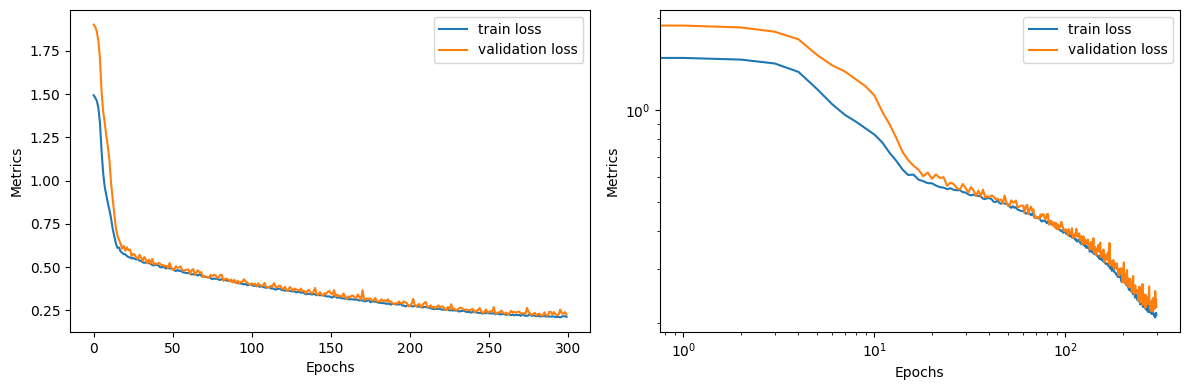

In [31]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=True)

In [32]:
from tfmelt.utils.evaluation import ensemble_predictions

# Evaluate the model performance on train, validation, and test data
n_iter = 100
pred_train_mean, pred_train_std = ensemble_predictions(bnn_model, x_train, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_val_mean, pred_val_std = ensemble_predictions(bnn_model, x_val, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_test_mean, pred_test_std = ensemble_predictions(bnn_model, x_test, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)

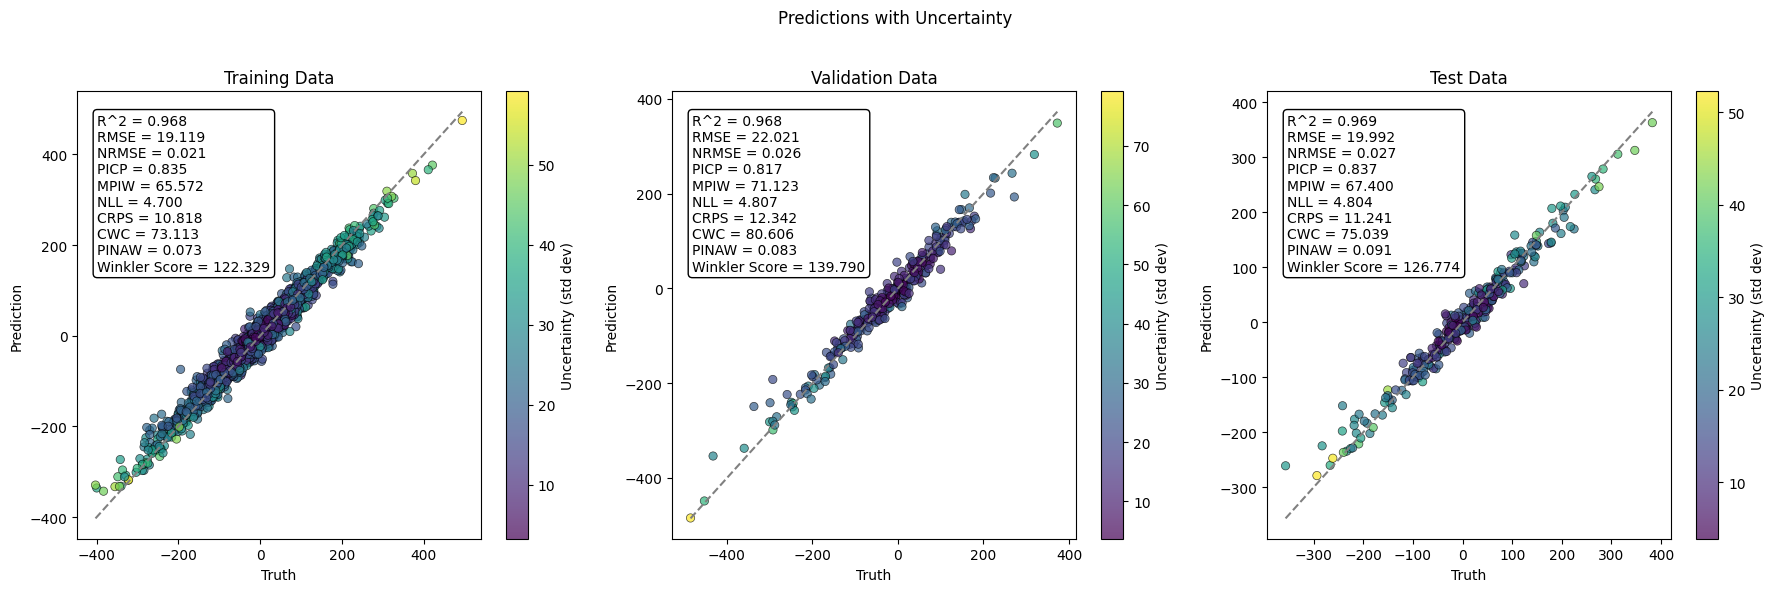

In [33]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot the predictions from the ensemble
plot_predictions_with_uncertainty(
    pred_train_mean, pred_train_std, y_train_real,
    pred_val_mean, pred_val_std, y_val_real,
    pred_test_mean, pred_test_std, y_test_real,
    # metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"]
    metrics_to_display=None, # Display all metrics
)

#### Aleatoric Uncertainty Predictions
Now examine aleatoric uncertainty predictions as well as combined predictions if there are more than 1 Bayesian layer. The number of Bayesian layers can be set in through the `bayesian_mask` input, which is a list of booleans indicating if a given layer should be made Bayesian.

TODO: Extract these visualization scripts into the tfmelt.utils.visualization submodule

In [34]:
from tfmelt.models import BayesianNeuralNetwork
from tensorflow.keras.optimizers import Adam

# BNN specific hyperparameters
dropout = 0.0
input_dropout = 0.0
do_aleatoric = True
batch_norm = True
use_batch_renorm = True
n_epochs = 200
l1_reg = 0
l2_reg = 0

node_list = [8, 8, 8]
bayesian_mask = [True, False, True]

# Create the model
bnn_model = BayesianNeuralNetwork(
    num_outputs=n_targets,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    output_activation=output_activation,
    num_points=x_train.shape[0],
    do_aleatoric=do_aleatoric,
    use_batch_renorm=use_batch_renorm,
    node_list=node_list,
    bayesian_mask=bayesian_mask,
)

# Compile the model
bnn_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
bnn_model.build(input_shape=(None, n_features))
bnn_model.summary()

/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tfmelt/models.py:574: UserWarning: Loss function is overridden when using aleatoric uncertainty. Using the negative log likelihood loss function.
  warnings.warn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "bayesian_neural_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output (BayesianAleatoricO  multiple                  102       
 utput)                                                          
                                                                 
 dense_block_0 (DenseBlock)  multiple                  128       
                                                                 
 bayesian_block_0 (Bayesian  multiple                  200       
 Block)                                                          
                                                                 
 bayesian_block_1 (Bayesian  multiple                  168       
 Block)                                                          
                                                                 
Total params: 598 (2.34 KB)
Trainable params: 526 (2.05 KB)
Non-trainable params: 72 (288.00 Byte)
________

In [35]:
# Train the model
history = bnn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/200
25/25 [==============================] - 1s 9ms/step - loss: 2.1792 - val_loss: 2.5455
Epoch 2/200
25/25 [==============================] - 0s 2ms/step - loss: 2.1052 - val_loss: 2.5328
Epoch 3/200
25/25 [==============================] - 0s 2ms/step - loss: 2.0304 - val_loss: 2.5067
Epoch 4/200
25/25 [==============================] - 0s 1ms/step - loss: 1.9104 - val_loss: 2.4447
Epoch 5/200
25/25 [==============================] - 0s 1ms/step - loss: 1.7920 - val_loss: 2.3161
Epoch 6/200
25/25 [==============================] - 0s 974us/step - loss: 1.6531 - val_loss: 2.1354
Epoch 7/200
25/25 [==============================] - 0s 979us/step - loss: 1.5503 - val_loss: 1.8928
Epoch 8/200
25/25 [==============================] - 0s 975us/step - loss: 1.4762 - val_loss: 1.6465
Epoch 9/200
25/25 [==============================] - 0s 1ms/step - loss: 1.4520 - val_loss: 1.4903
Epoch 10/200
25/25 [==============================] - 0s 981us/step - loss: 1.3952 - val_loss: 1.4714
E

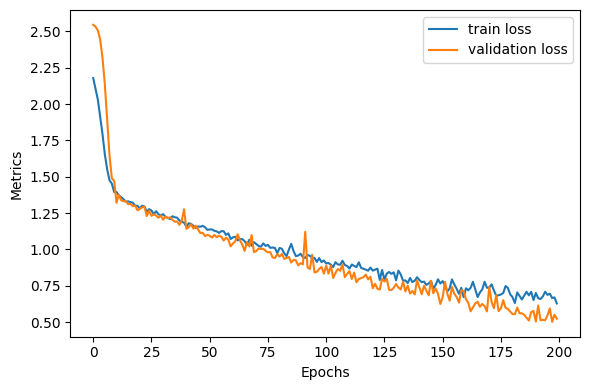

In [36]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=False)

In [37]:
# Evaluate the model performance with Monte Carlo ensemble predictions for Aleatoric and Epistemic Uncertainty
import numpy as np
import tensorflow_probability as tfp

num_preds = 100
pred_norm_train = np.stack([bnn_model(x_train, training=False) for _ in range(num_preds)], axis=0)
pred_norm_val = np.stack([bnn_model(x_val, training=False) for _ in range(num_preds)], axis=0)
pred_norm_test = np.stack([bnn_model(x_test, training=False) for _ in range(num_preds)], axis=0)

# If we are using aleatoric uncertainty, we have to unscale the distribution parameters
if do_aleatoric:
    pred_train = np.stack([tfp.distributions.Normal(loc=y_normalizer.inverse_transform(y.mean()).astype(np.float32), scale=np.float32(y_normalizer.scale_) * y.stddev()) for y in pred_norm_train])
    pred_val = np.stack([tfp.distributions.Normal(loc=y_normalizer.inverse_transform(y.mean()).astype(np.float32), scale=np.float32(y_normalizer.scale_) * y.stddev()) for y in pred_norm_val])
    pred_test = np.stack([tfp.distributions.Normal(loc=y_normalizer.inverse_transform(y.mean()).astype(np.float32), scale=np.float32(y_normalizer.scale_) * y.stddev()) for y in pred_norm_test])

    pred_mean_train = np.stack([y.mean().numpy() for y in pred_train]).mean(axis=0)
    pred_eu_train = np.stack([y.mean().numpy() for y in pred_train]).std(axis=0)
    pred_au_train = np.stack([y.stddev().numpy() for y in pred_train]).mean(axis=0)

    pred_mean_val = np.stack([y.mean().numpy() for y in pred_val]).mean(axis=0)
    pred_eu_val = np.stack([y.mean().numpy() for y in pred_val]).std(axis=0)
    pred_au_val = np.stack([y.stddev().numpy() for y in pred_val]).mean(axis=0)

    pred_mean_test = np.stack([y.mean().numpy() for y in pred_test]).mean(axis=0)
    pred_eu_test = np.stack([y.mean().numpy() for y in pred_test]).std(axis=0)
    pred_au_test = np.stack([y.stddev().numpy() for y in pred_test]).mean(axis=0)
    
# If we are not using aleatoric uncertainty, we can unscale the predictions directly
else:
    pred_train = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_train], axis=0)
    pred_val = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_val], axis=0)
    pred_test = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_test], axis=0)

    # Compute the mean and standard deviation of the predictions
    pred_mean_train = np.mean(pred_train, axis=0)
    pred_eu_train = np.std(pred_train, axis=0)
    pred_au_train = np.zeros(pred_mean_train.shape)

    pred_mean_val = np.mean(pred_val, axis=0)
    pred_eu_val = np.std(pred_val, axis=0)
    pred_au_val = np.zeros(pred_mean_val.shape)

    pred_mean_test = np.mean(pred_test, axis=0)
    pred_eu_test = np.std(pred_test, axis=0)
    pred_au_test = np.zeros(pred_mean_test.shape)



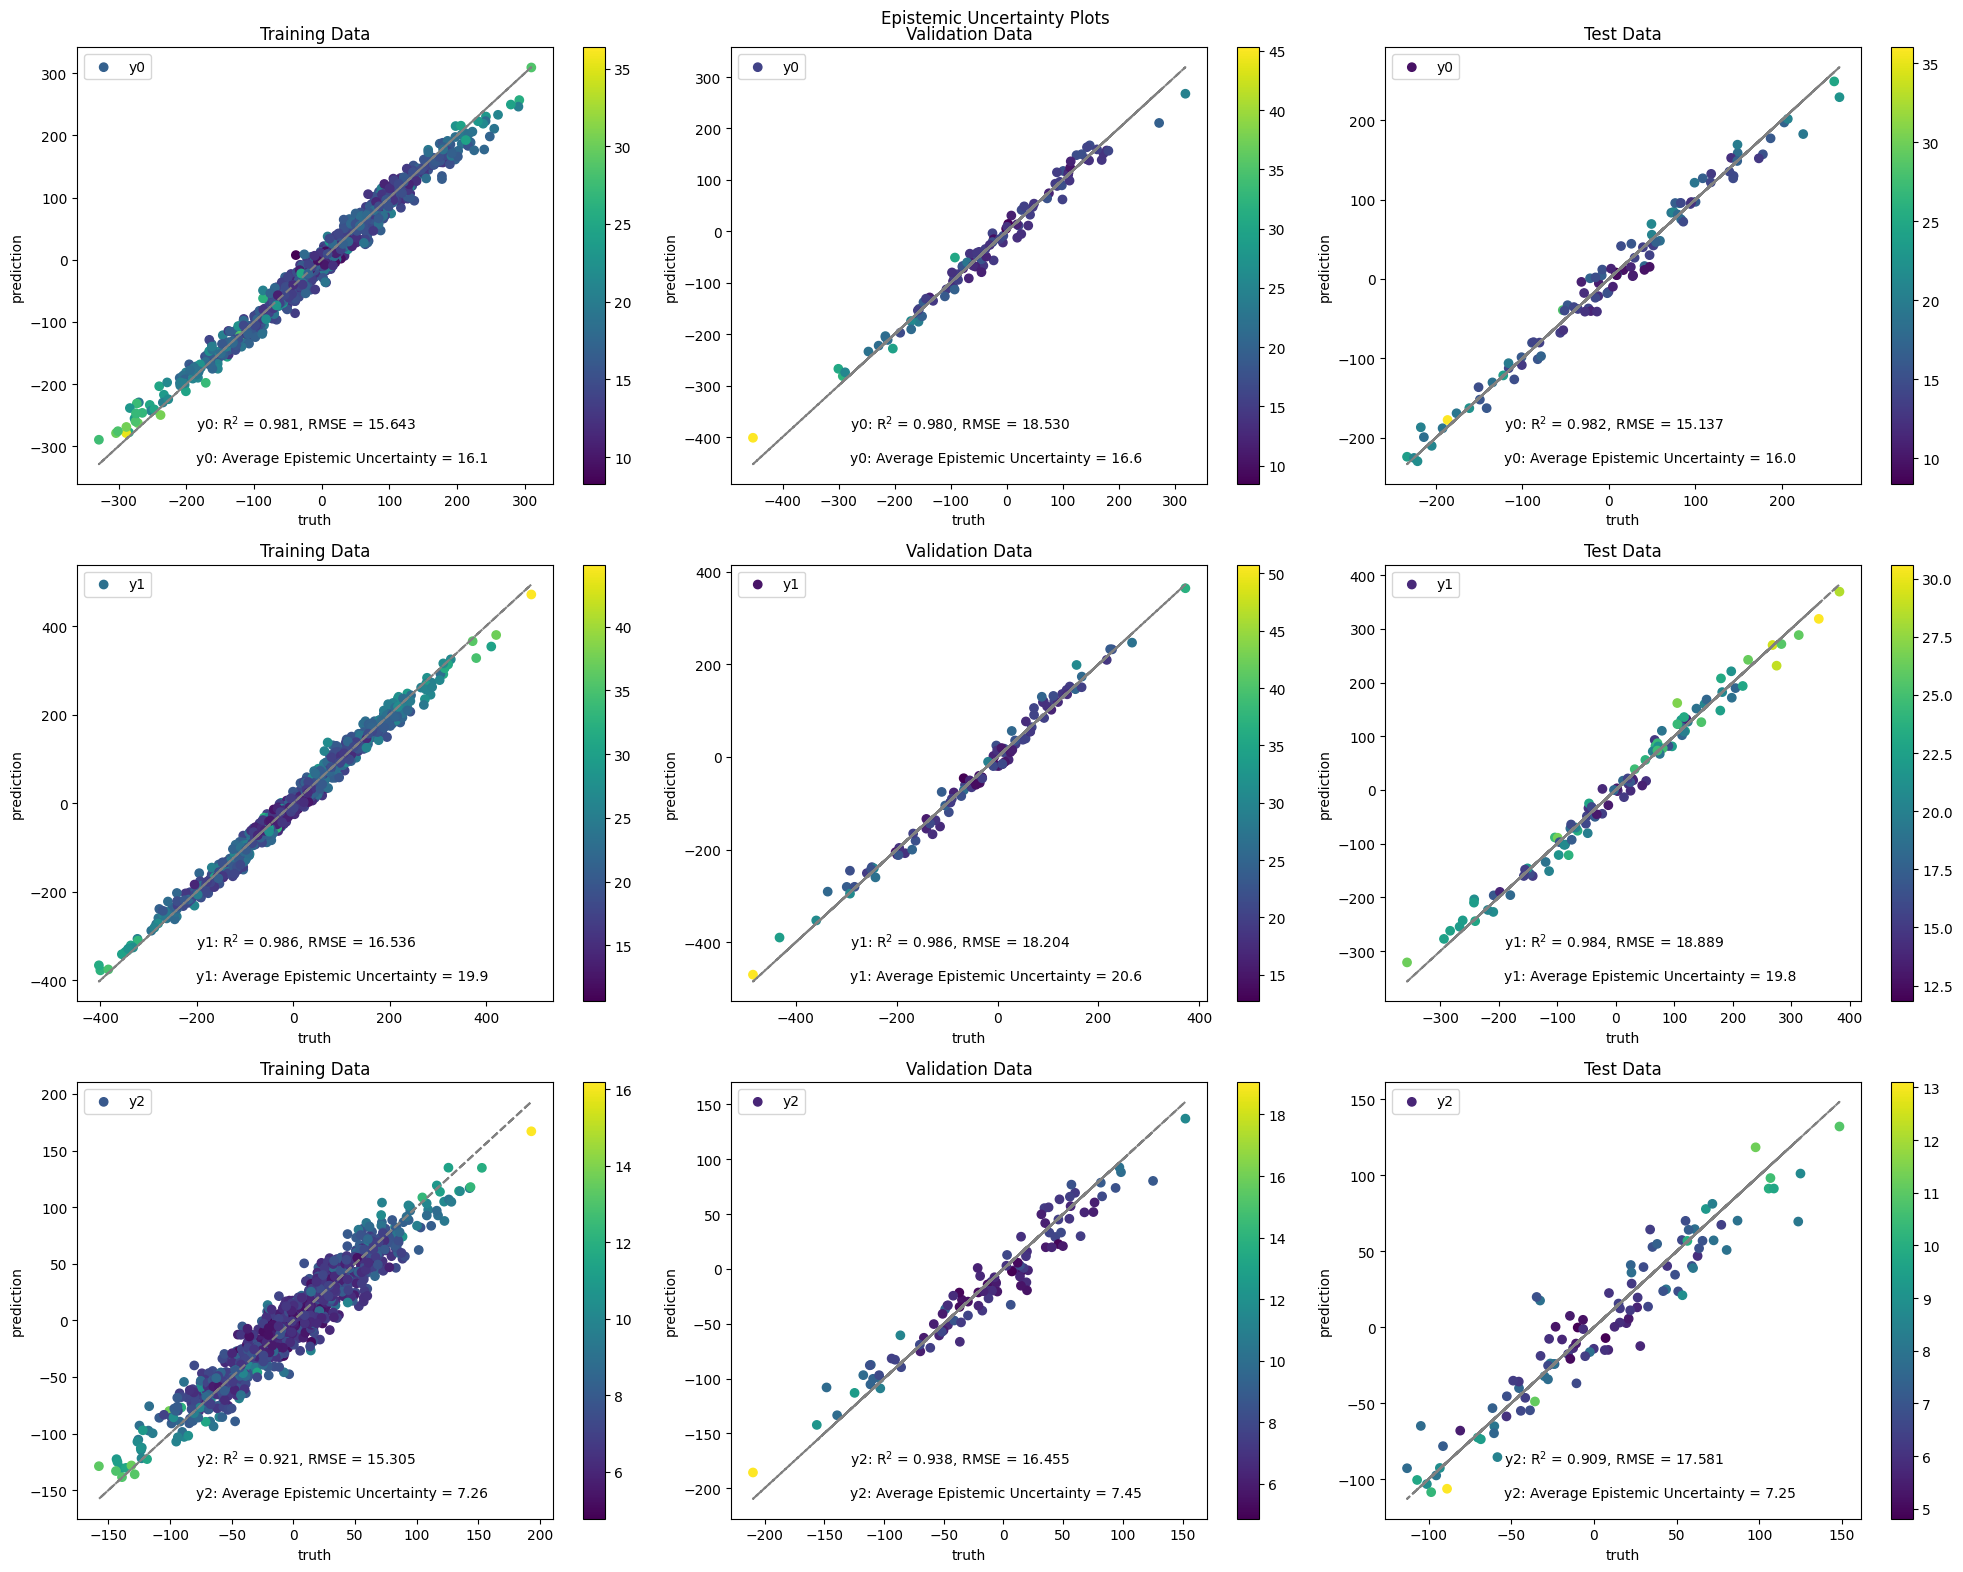

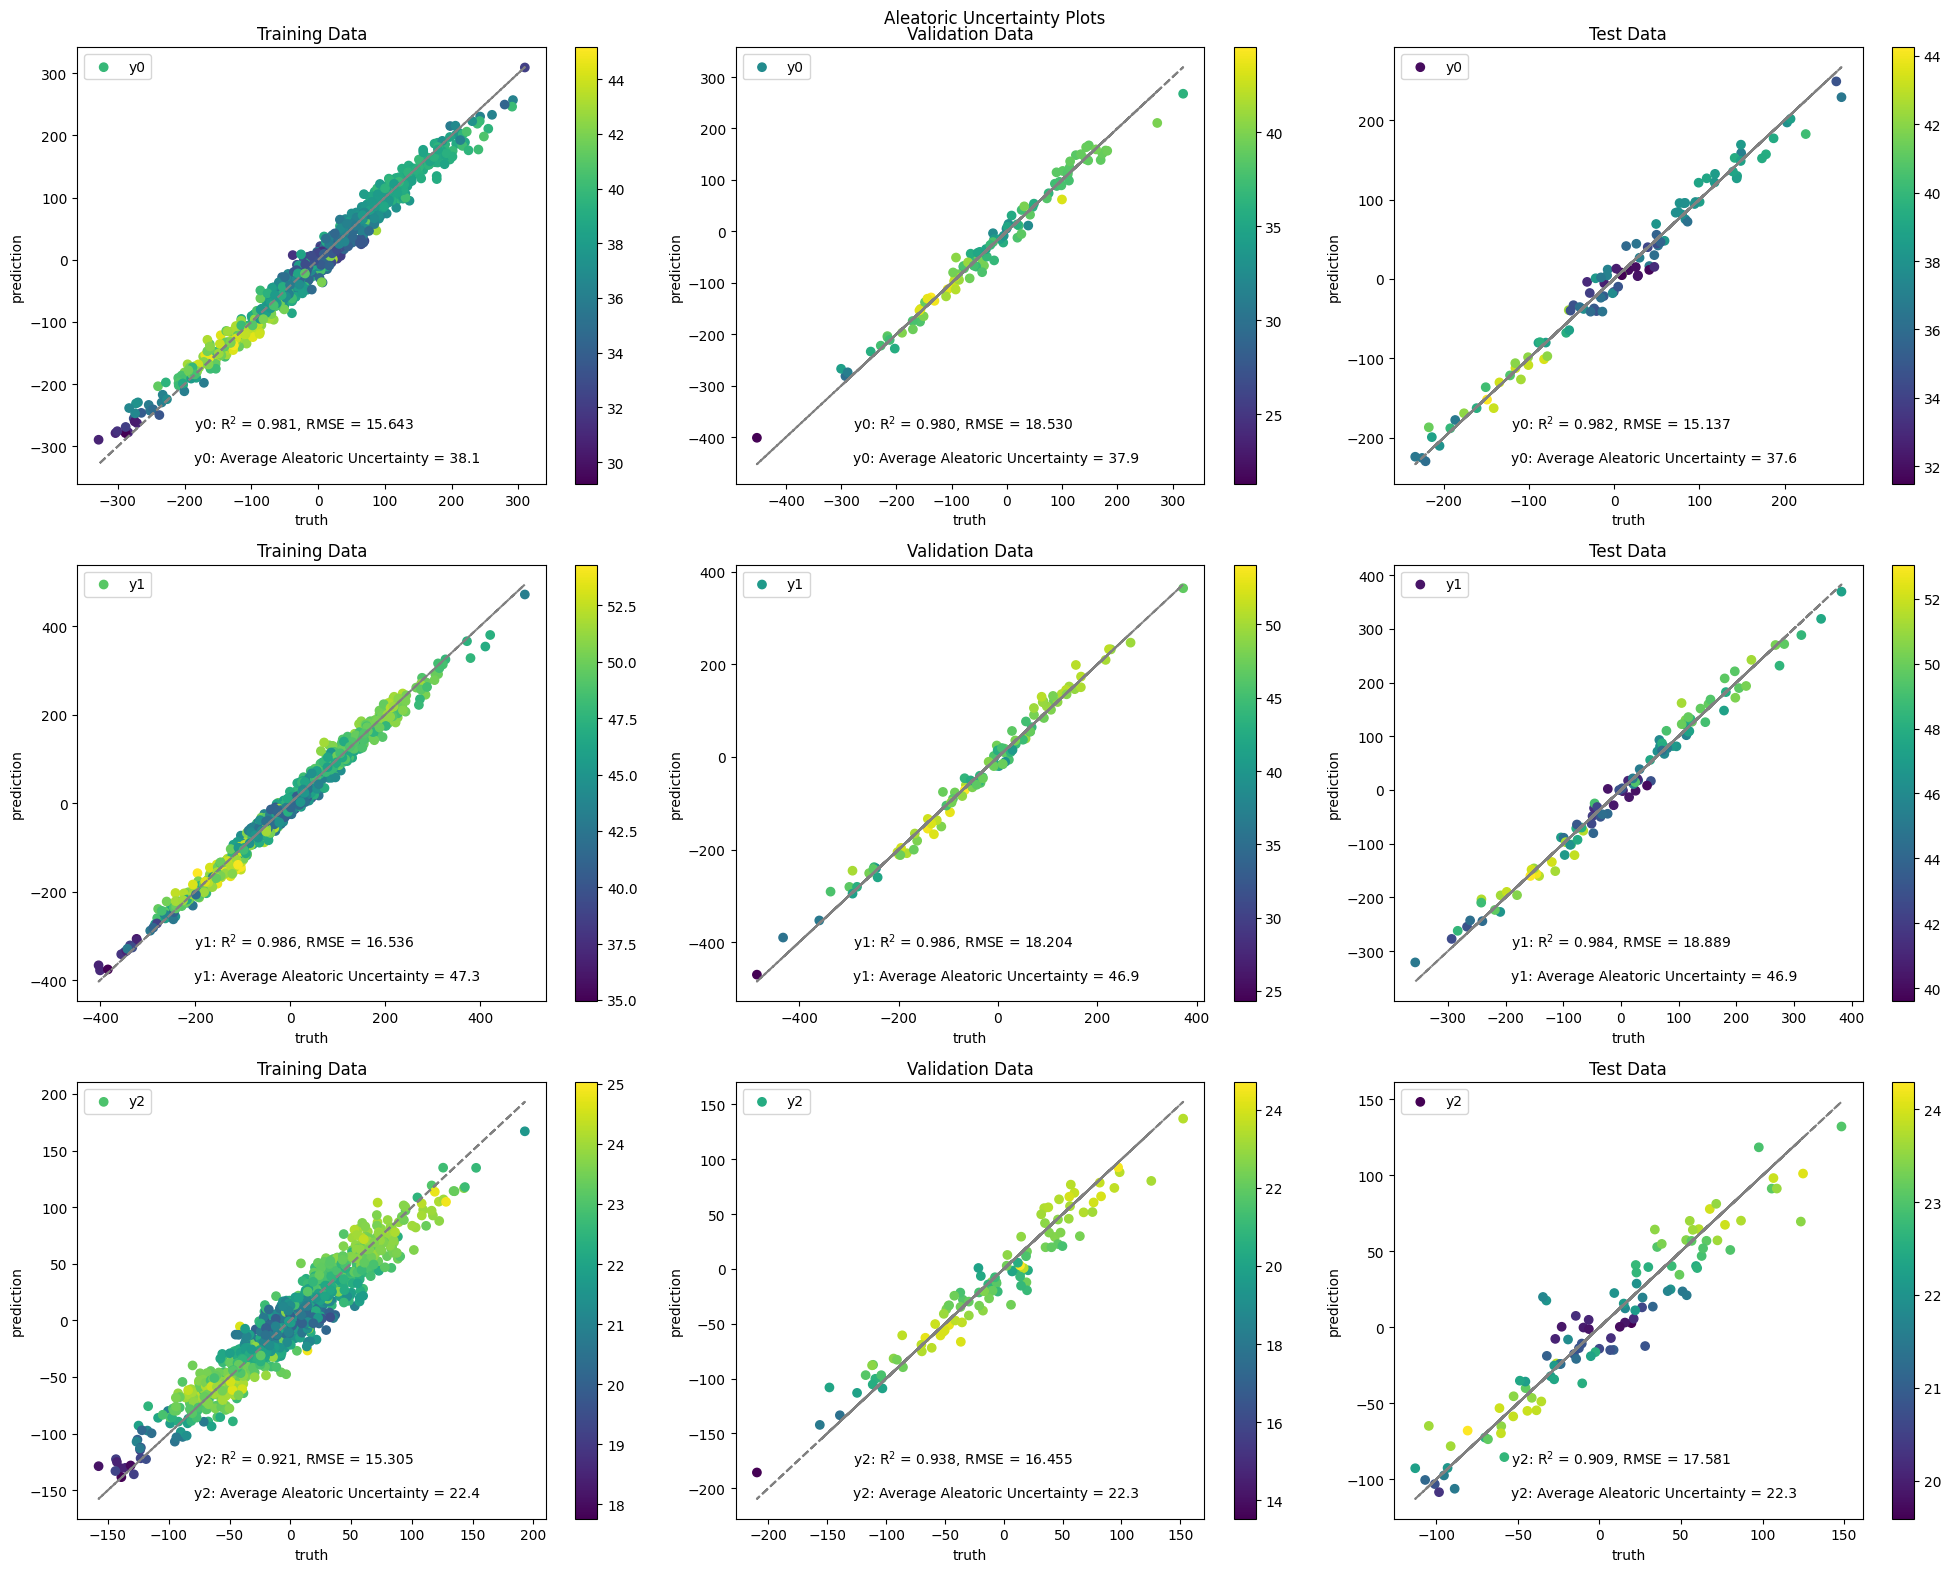

In [38]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/truth)**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_mean_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_mean_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_mean_test, y_test_real)


# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    ax1.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.text(x=0.25, y=0.05, s=rf"y{i}: Average Epistemic Uncertainty = {np.mean(pred_eu_train[:, i]):0.3}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    ax2.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.text(x=0.25, y=0.05, s=rf"y{i}: Average Epistemic Uncertainty = {np.mean(pred_eu_val[:, i]):0.3}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.05, s=rf"y{i}: Average Epistemic Uncertainty = {np.mean(pred_eu_test[:, i]):0.3}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Epistemic Uncertainty Plots')
fig.tight_layout()
plt.show()

# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    ax1.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.text(x=0.25, y=0.05, s=rf"y{i}: Average Aleatoric Uncertainty = {np.mean(pred_au_train[:, i]):0.3}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    ax2.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.text(x=0.25, y=0.05, s=rf"y{i}: Average Aleatoric Uncertainty = {np.mean(pred_au_val[:, i]):0.3}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.05, s=rf"y{i}: Average Aleatoric Uncertainty = {np.mean(pred_au_test[:, i]):0.3}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Aleatoric Uncertainty Plots')
fig.tight_layout()
plt.show()